In [1]:
# ! pip install folium
# ! pip install geopandas
# ! pip install geodatasets
# ! pip install contextily
import pandas as pd 
import matplotlib.pyplot as plt
import sys
import os 
import geopandas as gpd
import geodatasets
import contextily as cx
from pyproj import Transformer
import numpy as np


In [2]:
vehicle_names = ["SEB880", "SEB882", "SEB883", "SEB885", "SEB888", "SEB889"]

PATH_TO_MF4 = "../Processed_data_new/01_Mf4_Extracted"

def load_csv_to_dic(path, v_names, ext="_eso.csv") -> dict:
    """ Return: dic with v_name as key and dataframe as value """
    dic = {}
    for vn in v_names:
        dic[vn] = pd.read_csv(os.path.join(path, vn + ext), parse_dates=['datetime'])
    return dic

dfEsoDic = load_csv_to_dic(path="../Processed_data_new/01_Eso_Extracted", v_names=vehicle_names, ext="_extracted_eso.csv")
dfMf4Dic = load_csv_to_dic(path="../Processed_data_new/01_Mf4_Extracted", v_names=vehicle_names, ext="_extracted_mf4.csv")
dfMergedDic = load_csv_to_dic(path="../Processed_data_new/04_Merged", v_names=vehicle_names, ext="_merged.csv")

dfEso = pd.DataFrame()
dfMf4 = pd.DataFrame()
dfMerged = pd.DataFrame()
for vehicle in vehicle_names:
    dfEso = pd.concat([dfEso, dfEsoDic[vehicle]])
    dfMf4 = pd.concat([dfMf4, dfMf4Dic[vehicle]], ignore_index=True)
    dfMerged = pd.concat([dfMerged, dfMergedDic[vehicle]])

/var/folders/66/86s66dd95nx0972mbj4kyl940000gn/T/ipykernel_93900/2798038460.py:9: DtypeWarning: Columns (14,24) have mixed types. Specify dtype option on import or set low_memory=False.
  dic[vn] = pd.read_csv(os.path.join(path, vn + ext), parse_dates=['datetime'])
/var/folders/66/86s66dd95nx0972mbj4kyl940000gn/T/ipykernel_93900/2798038460.py:9: DtypeWarning: Columns (28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  dic[vn] = pd.read_csv(os.path.join(path, vn + ext), parse_dates=['datetime'])
/var/folders/66/86s66dd95nx0972mbj4kyl940000gn/T/ipykernel_93900/2798038460.py:9: DtypeWarning: Columns (28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  dic[vn] = pd.read_csv(os.path.join(path, vn + ext), parse_dates=['datetime'])
/var/folders/66/86s66dd95nx0972mbj4kyl940000gn/T/ipykernel_93900/2798038460.py:9: DtypeWarning: Columns (16,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=Fa

# Folium to load an html page

In [ ]:
import folium

gps_data = dfMf4Dic["SEB882"][["latitude", "longitude"]]
# dont support nan :(
dfMf4Dic["SEB882"].dropna(subset=["latitude", "longitude"], inplace=True)

# Create a base map centered at a specific location
m = folium.Map(location=[38.0, -95.0], zoom_start=3)

## load geojson for boundaries, unfortunately only region availabel and messy
# germany_geojson = "DE.geojson"
# folium.GeoJson(germany_geojson, name="Germany").add_to(m)

# Iterate through the DataFrame to add routes
for route_id, group in dfMf4Dic["SEB882"].groupby("session"):
    coordinates = group[["latitude", "longitude"]].values.tolist()
    folium.PolyLine(locations=coordinates, color='blue').add_to(m)

# Add markers for each GPS coordinate
for coord in gps_data:
    folium.CircleMarker(location=coord, radius=5, color='blue', fill=True, fill_color='blue').add_to(m)

# Save the map as an HTML file
m.save('gps_map.html')

# GeoPandas (only map)

/var/folders/66/86s66dd95nx0972mbj4kyl940000gn/T/ipykernel_18742/23082880.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


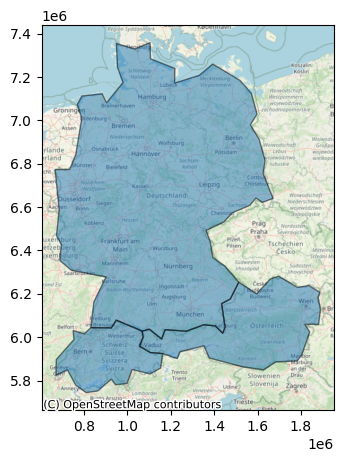

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for Germany
germany = world[world['name'].isin(['Germany', 'Austria', 'Switzerland'])]

# Plot the map of Germany
germ = germany.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(5, 5))
germ.plot(ax=ax, alpha=0.5, edgecolor="k")
cx.add_basemap(ax, zoom=6, source=cx.providers.OpenStreetMap.DE)

# Geopandas (map with routes)

/var/folders/66/86s66dd95nx0972mbj4kyl940000gn/T/ipykernel_18742/1323300058.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


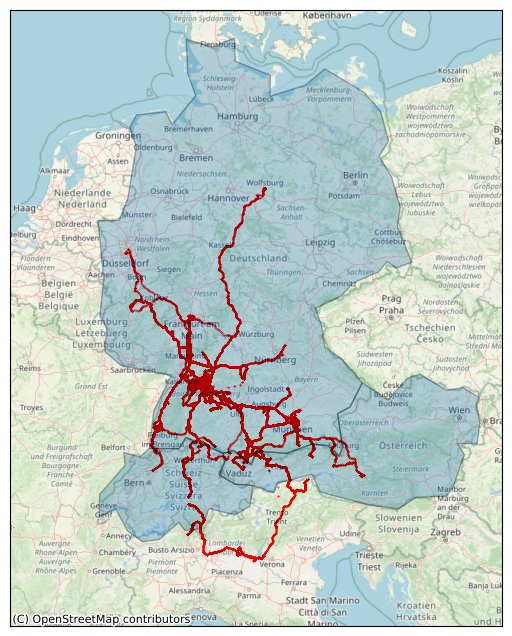

In [23]:

vehicle_names = ["SEB880", "SEB882", "SEB883", "SEB885", "SEB888", "SEB889"]
#vehicle_names = [ "SEB882"]

# Load the natural earth dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = world[world['name'].isin(['Germany', 'Austria', 'Switzerland'])]
germ = germany.to_crs(epsg=3857) # Web Mercator projection (3857)
ax = germ.plot(figsize=(8, 8), alpha=0.3, edgecolor="k")
ax.set_xticks([])
ax.set_yticks([])

car_gdfs = {}
for vehicle in vehicle_names:
    gps_gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(dfMf4Dic[vehicle]["longitude"],dfMf4Dic[vehicle]["latitude"]),
        crs="EPSG:4326"
    )
    car_gdfs[vehicle] = gps_gdf.to_crs(epsg=3857)

colors = ['#ef476f', '#ffd166', '#06d6a0', '#118ab2', '#073b4c', '#ffafcc']
for idx, (car_name, car_gdf) in enumerate(car_gdfs.items()):
    car_gdf.plot(ax=ax, color="red", marker='o', markersize=0.1,  alpha=0.01, label=car_name) # marker='o', markersize=0.5,

# Add background map 
cx.add_basemap(ax, zoom=6, source=cx.providers.OpenStreetMap.DE)

# # Customized axis limit
# south, north, east, west = 45, 53, 13.5, 5
# transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
# bbox = transformer.transform(west, south), transformer.transform(east, north)
# ax.set_xlim(bbox[0][0], bbox[1][0])
# ax.set_ylim(bbox[0][1], bbox[1][1])
plt.show()

/var/folders/66/86s66dd95nx0972mbj4kyl940000gn/T/ipykernel_18742/3092084769.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


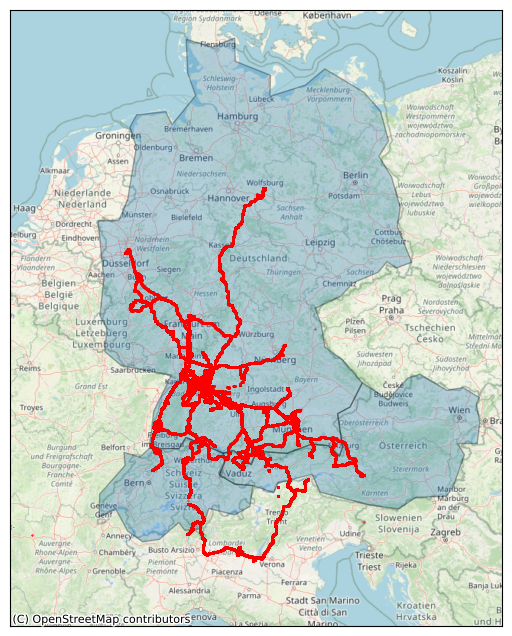

In [48]:

vehicle_names = ["SEB880", "SEB882", "SEB883", "SEB885", "SEB888", "SEB889"]
#vehicle_names = [ "SEB882"]

# Load the natural earth dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = world[world['name'].isin(['Germany', 'Austria', 'Switzerland'])]
germ = germany.to_crs(epsg=3857) # Web Mercator projection (3857)
ax = germ.plot(figsize=(8, 8), alpha=0.3, edgecolor="k")
ax.set_xticks([])
ax.set_yticks([])

car_gdfs = {}
for vehicle in vehicle_names:
    gps_gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(dfMf4Dic[vehicle]["longitude"],dfMf4Dic[vehicle]["latitude"]),
        crs="EPSG:4326"
    )
    car_gdfs[vehicle] = gps_gdf.to_crs(epsg=3857)

colors = ['#ef476f', '#ffd166', '#06d6a0', '#118ab2', '#073b4c', '#ffafcc']
for idx, (car_name, car_gdf) in enumerate(car_gdfs.items()):
    car_gdf.plot(ax=ax, color="red", marker='o', markersize=0.1,  alpha=0.5, label=car_name) # marker='o', markersize=0.5,

# Add background map 
cx.add_basemap(ax, zoom=6, source=cx.providers.OpenStreetMap.DE)

# # Customized axis limit
# south, north, east, west = 45, 53, 13.5, 5
# transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
# bbox = transformer.transform(west, south), transformer.transform(east, north)
# ax.set_xlim(bbox[0][0], bbox[1][0])
# ax.set_ylim(bbox[0][1], bbox[1][1])
plt.show()

/var/folders/66/86s66dd95nx0972mbj4kyl940000gn/T/ipykernel_18742/1290306215.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


vehicle:  SEB880
vehicle:  SEB882
vehicle:  SEB883
vehicle:  SEB885
vehicle:  SEB888
vehicle:  SEB889


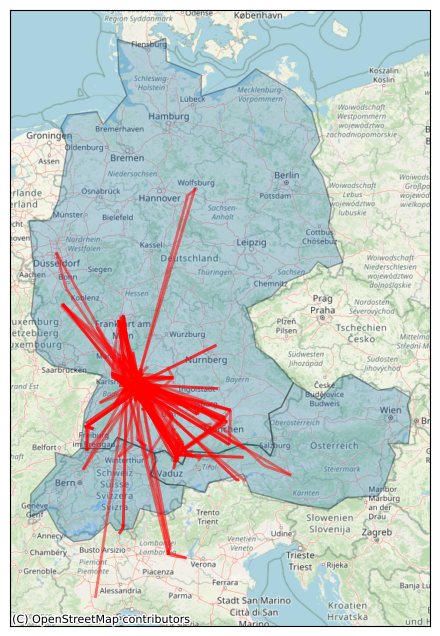

In [50]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from pyproj import Transformer
from tqdm import tqdm
from shapely.geometry import Point, LineString  # Import LineString


# Define vehicle names
vehicle_names = ["SEB880", "SEB882", "SEB883", "SEB885", "SEB888", "SEB889"]
#vehicle_names = ["SEB882"]

# Load the natural earth dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = world[world['name'].isin(['Germany', 'Austria', 'Switzerland'])]
germ = germany.to_crs(epsg=3857)  # Web Mercator projection (3857)

# Plot the base map
ax = germ.plot(figsize=(8, 8), alpha=0.3, edgecolor="k")
ax.set_xticks([])
ax.set_yticks([])

car_gdfs = {}
for vehicle in vehicle_names:
    gps_gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(dfMf4Dic[vehicle]["longitude"], dfMf4Dic[vehicle]["latitude"]),
        crs="EPSG:4326"
    )
    car_gdfs[vehicle] = gps_gdf.to_crs(epsg=3857)

colors = ['#ef476f', '#ffd166', '#06d6a0', '#118ab2', '#073b4c', '#ffafcc']
colors = ['red', 'red', 'red', 'red', 'red', 'red']
# for idx, (car_name, car_gdf) in enumerate(car_gdfs.items()):
#     car_gdf.plot(ax=ax, color=colors[idx], marker='o', markersize=0.1, alpha=0.01, label=car_name)

# Extract and plot lines connecting start and end points for each session

for vehicle, car_gdf in car_gdfs.items():
    df = dfMf4Dic[vehicle]
    sessions = df["session"].unique()
    print("vehicle: ", vehicle)
    for session in (sessions):
        session_gdf = df[df["session"] == session]
        session_gdf = session_gdf.dropna(subset=["longitude", "latitude"])  # Drop rows with missing coordinates
        if len(session_gdf) >= 2:  # At least two points for a line
            start_point = Point(session_gdf.iloc[0]["longitude"], session_gdf.iloc[0]["latitude"])
            end_point = Point(session_gdf.iloc[-1]["longitude"], session_gdf.iloc[-1]["latitude"])

            line = LineString([start_point, end_point])  # Create LineString

            line_gdf = gpd.GeoDataFrame(geometry=[line], crs="EPSG:4326")
            line_gdf = line_gdf.to_crs("EPSG:3857")

            line_gdf.plot(ax=ax, linestyle='-', linewidth=2, color=colors[vehicle_names.index(vehicle)], alpha=0.5)

# Add background map
cx.add_basemap(ax, zoom=6, source=cx.providers.OpenStreetMap.DE)

# Show the plot
plt.show()


/var/folders/66/86s66dd95nx0972mbj4kyl940000gn/T/ipykernel_18742/196808116.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


vehicle:  SEB880
vehicle:  SEB882
vehicle:  SEB883
vehicle:  SEB885
vehicle:  SEB888
vehicle:  SEB889


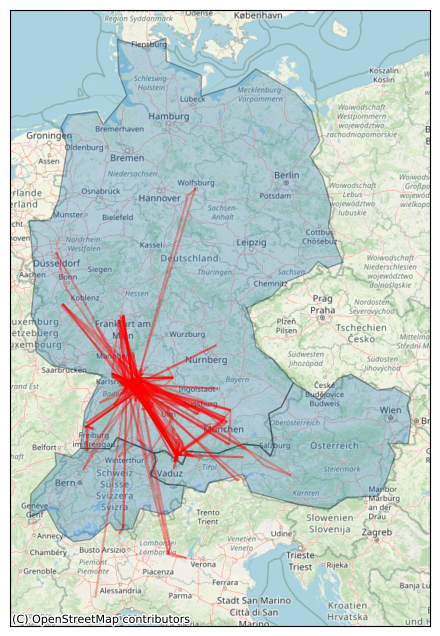

In [54]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from pyproj import Transformer
from tqdm import tqdm
from shapely.geometry import Point, LineString  # Import LineString


# Define vehicle names
vehicle_names = ["SEB880", "SEB882", "SEB883", "SEB885", "SEB888", "SEB889"]
#vehicle_names = ["SEB882"]

# Load the natural earth dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = world[world['name'].isin(['Germany', 'Austria', 'Switzerland'])]
germ = germany.to_crs(epsg=3857)  # Web Mercator projection (3857)

# Plot the base map
ax = germ.plot(figsize=(8, 8), alpha=0.3, edgecolor="k")
ax.set_xticks([])
ax.set_yticks([])

car_gdfs = {}
for vehicle in vehicle_names:
    gps_gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(dfMf4Dic[vehicle]["longitude"], dfMf4Dic[vehicle]["latitude"]),
        crs="EPSG:4326"
    )
    car_gdfs[vehicle] = gps_gdf.to_crs(epsg=3857)

colors = ['#ef476f', '#ffd166', '#06d6a0', '#118ab2', '#073b4c', '#ffafcc']
colors = ['red', 'red', 'red', 'red', 'red', 'red']
# for idx, (car_name, car_gdf) in enumerate(car_gdfs.items()):
#     car_gdf.plot(ax=ax, color=colors[idx], marker='o', markersize=0.1, alpha=0.01, label=car_name)

# Extract and plot lines connecting start and end points for each session

for vehicle, car_gdf in car_gdfs.items():
    df = dfMf4Dic[vehicle]
    sessions = df["session"].unique()
    print("vehicle: ", vehicle)
    for session in (sessions):
        session_gdf = df[df["session"] == session]
        
        # Skip session if no valid coordinates
        if session_gdf.dropna(subset=["longitude", "latitude"]).empty:
            continue
        
        # Find the next available valid start and end points
        valid_start_idx = session_gdf["longitude"].notna().idxmax()
        valid_end_idx = session_gdf["longitude"].notna()[::-1].idxmax()
            

        start_point = Point(session_gdf.loc[valid_start_idx, "longitude"], session_gdf.loc[valid_start_idx, "latitude"])
        end_point = Point(session_gdf.loc[valid_end_idx, "longitude"], session_gdf.loc[valid_end_idx, "latitude"])

        line = LineString([start_point, end_point])

        line_gdf = gpd.GeoDataFrame(geometry=[line], crs="EPSG:4326")
        line_gdf = line_gdf.to_crs("EPSG:3857")

        line_gdf.plot(ax=ax, marker='o', markersize=0.1, color=colors[vehicle_names.index(vehicle)], alpha=0.3)

# Add background map
cx.add_basemap(ax, zoom=6, source=cx.providers.OpenStreetMap.DE)

# Show the plot
plt.show()


# Milos

In [ ]:
import numpy as np

# dfMf4Dic["SEB882"]
df_gps = dfMf4[['longitude', 'latitude']].round(1)
df_gps = df_gps.groupby(['longitude', 'latitude']).size().reset_index(name='Times')
df_gps['Times_log'] = np.log1p(df_gps['Times'])
df_gps

,longitude,latitude,Times,Times_log
0,4.1,45.9,5,1.791759
1,4.2,48.2,1,0.693147
2,5.5,46.8,1,0.693147
3,5.6,48.4,1,0.693147
4,5.7,48.6,1,0.693147
...,...,...,...,...
728,13.4,47.4,565,6.338594
729,13.5,47.1,1577,7.363914
730,13.5,47.2,412,6.023448
731,13.6,46.2,4,1.609438


In [5]:
germany = gpd.read_file('Maps/plz-2stellig.shp', dtype={'plz': str})
swiss = gpd.read_file("Maps/swiss5.geojson")
austria = gpd.read_file("Maps/austria2.geojson")
italy = gpd.read_file("Maps/italy.geojson")



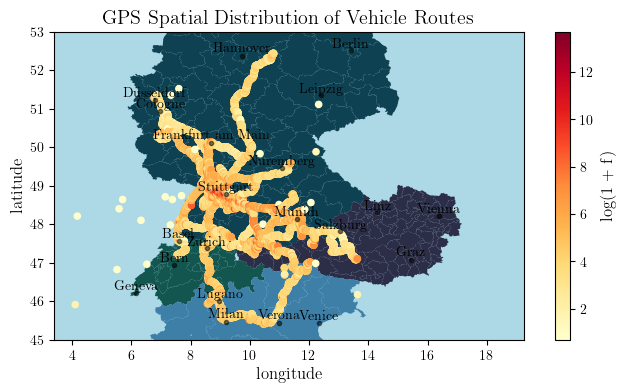

In [11]:
# dfMf4Dic["SEB882"]
df_gps = dfMf4[['longitude', 'latitude']].round(2)
df_gps = df_gps.groupby(['longitude', 'latitude']).size().reset_index(name='Times')
df_gps['Times_log'] = np.log1p(df_gps['Times'])
df_gps

plt.rcParams['figure.figsize'] = [8, 4]

top_cities = {
    'Berlin': (13.404954, 52.520008), 
    'Cologne': (6.953101, 50.935173),
    'Düsseldorf': (6.782048, 51.227144),
    'Frankfurt am Main': (8.682127, 50.110924),
    #'Hamburg': (9.993682, 53.551086),
    'Leipzig': (12.387772, 51.343479),
    'Munich': (11.576124, 48.137154),
    #'Dortmund': (7.468554, 51.513400),
    'Stuttgart': (9.181332, 48.777128),
    'Nuremberg': (11.077438, 49.449820),
    'Hannover': (9.73322, 52.37052),
    'Zurich': (8.541694, 47.376888),
    'Lugano': (8.953620,46.003601),
    'Verona': (10.993313, 45.438618),
    'Vienna': (16.3738, 48.2082),
    'Graz': (15.4395, 47.0707),
    'Linz': (14.2914, 48.3069),
    'Salzburg': (13.0430, 47.8095),
    'Geneva': (6.1432, 46.2044),
    'Basel': (7.5890, 47.5596),
    'Bern': (7.4474, 46.9480),
    'Milan': (9.1900, 45.4642),
    'Venice': (12.3155, 45.4408),
    #'Bologna': (11.3426, 44.4949)
}

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12,  # Adjust the font size for all elements
    "axes.labelsize": 12,  # Font size of axis labels
    "xtick.labelsize": 10,  # Font size of x-axis tick labels
    "ytick.labelsize": 10,  # Font size of y-axis tick labels
    "legend.fontsize": 10,  # Font size of legend
    "figure.titlesize": 12,  # Font size of figure title
})

fig, ax = plt.subplots()

germany.plot(ax=ax, color='#073b4c', alpha=0.96)
swiss.plot(ax=ax, color='#0c5149', alpha=0.96)
austria.plot(ax=ax, color='#272640', alpha=0.96)
italy.plot(ax=ax, color='#3a7ca5', alpha=0.96)

for c in top_cities.keys():
    # Plot city name.
    ax.text(
        x=top_cities[c][0], 
        # Add small shift to avoid overlap with point.
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=10,
        ha='center', 
    )
    # Plot city location centroid.
    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        markersize=3,
        c='black', 
        alpha=0.5
    )

df_gps.plot(x='longitude', y='latitude', kind="scatter", c="Times_log",
        colormap="YlOrRd", ax=ax, s=20)

cbar = ax.collections[-1].colorbar
cbar.set_label('log(1 + f)')

ax.set(
    title='GPS Spatial Distribution of Vehicle Routes', 
    aspect=1.3, 
    facecolor='lightblue'
)

ax.set_ylim(45.0, 53.0)

plt.savefig("/Users/wannerje/Dropbox/Porsche/eth_report/Img/gps_dist.pdf", format="pdf", bbox_inches="tight")


In [19]:
df = dfMerged[["session", "odometer"]]
tot_m = []
for sess in df.session.unique():
    df_sess = df[df.session == sess]
    odometer = sorted(df_sess.odometer)    
    # Remove all zeros from the sorted list
    odometer = [value for value in odometer if value != 0]
    tot_m.append(odometer[-1] - odometer[0])
    

43.66550116550116
74930.0
25.837931034482757


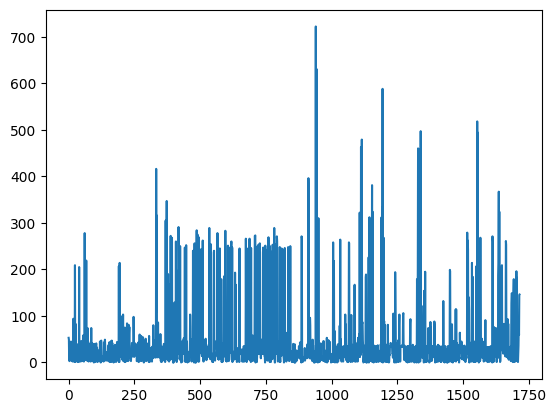

In [26]:
print(np.mean(tot_m))
print(sum(tot_m))
print(sum(tot_m)/2900)
plt.plot(tot_m)